# Аналитика в Яндекс.Афише


## Описание проекта
Вас пригласили на стажировку в отдел аналитики Яндекс.Афиши. Первое задание: помочь маркетологам оптимизировать маркетинговые затраты.
У вас в распоряжении есть данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
* лог сервера с данными о посещениях сайта Яндекс.Афиши,
* выгрузка всех заказов за этот период,
* статистика рекламных расходов.

Вы изучите:
* как люди пользуются продуктом,
* когда они начинают покупать,
* сколько денег приносит каждый клиент
* когда клиент окупается.

## Описание данных
Таблица visits (лог сервера с информацией о посещениях сайта):
* Uid — уникальный идентификатор пользователя
* Device — категория устройства пользователя
* Start Ts — дата и время начала сессии
* End Ts — дата и время окончания сессии
* Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
* Uid — уникальный id пользователя, который сделал заказ
* Buy Ts — дата и время заказа
* Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
* source_id — идентификатор рекламного источника
* dt — дата
* costs — затраты на этот рекламный источник в этот день

## Оглавление:
- [Шаг 1. Загрузите данные и подготовьте их к анализу](#1)
- [Шаг 2. Постройте отчёты и посчитайте метрики](#2)
- [Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?](#3)



### <a id='1'>Шаг 1. Загрузите данные и подготовьте их к анализу</a>
Загрузите данные о визитах, заказах и расходах в переменные. Оптимизируйте данные для анализа. Убедитесь, что тип данных в каждой колонке — правильный.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
def fun(data):
    display(data.head())
    display(data.info())

In [3]:
visits = pd.read_csv('/media/max/TOSHIBA EXT/YANDEX.Практикум/Файлы/visits_log.csv')

fun(visits)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


None

In [4]:
#Переведем значения колонок с началом и концом сессии из строкового формата в формат дата-время
visits['End Ts'] = pd.to_datetime(visits['End Ts'],format="%Y-%m-%d %H:%M")
visits['Start Ts'] = pd.to_datetime(visits['Start Ts'],format="%Y-%m-%d %H:%M")


In [5]:
#Проверим наличие сбоев.Время завершения сессии не может быть меньше времени начала сессии
print(visits[visits['End Ts']<visits['Start Ts']])


         Device              End Ts  Source Id            Start Ts  \
4181    desktop 2018-03-25 03:18:00          3 2018-03-25 03:50:00   
177972  desktop 2018-03-25 03:09:00          9 2018-03-25 03:55:00   

                         Uid  
4181    13092152539246794986  
177972   4621202742905035453  


In [6]:
#Удалим эти аномалии
visits = visits[visits['End Ts']>=visits['Start Ts']]


In [7]:
orders = pd.read_csv('/media/max/TOSHIBA EXT/YANDEX.Практикум/Файлы/orders_log.csv')

fun(orders)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


None

In [8]:
#Переведем значения колонки с датой ив ременем заказа из строкового формата в формат дата-время
orders['Buy Ts'] = pd.to_datetime(orders['Buy Ts'],format="%Y-%m-%d %H:%M")

In [9]:
costs = pd.read_csv('/media/max/TOSHIBA EXT/YANDEX.Практикум/Файлы/costs.csv')

fun(costs)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


None

In [10]:
#Переведем значения колонки дата из строкового формата в формат дата-время
costs['dt'] = pd.to_datetime(costs['dt'],format="%Y-%m-%d")

## Вывод
Изменили тип данных в  колонках с датой и временем и подготовили таблицы к дальнейшему анализу.Никаких пропусков в таблицах нет.Таблица visits имеет две строки , в которых время окончание сессии меньше времени начала сессии, что невозможно. Поэтому эти строки были удалены.

### <a id='2'>Шаг 2. Постройте отчёты и посчитайте метрики</a>

### 2.1. Продукт
- Сколько людей пользуются в день, неделю, месяц?
- Сколько сессий в день?
- Сколько длится одна сессия?
- Как часто люди возвращаются?

In [11]:
#Посмотрим за какой период у нас данные
print(visits['Start Ts'].max())
print(visits['Start Ts'].min())

2018-05-31 23:59:00
2017-06-01 00:01:00


In [12]:
#Выделем из данных по посещению дни недели, недели и месяцы
visits['start_day'] = visits['Start Ts'].dt.weekday
visits['start_week'] = visits['Start Ts'].dt.week
visits['start_month'] = visits['Start Ts'].dt.month
visits['start_date'] = visits['Start Ts'].dt.date


In [13]:
#Посчитаем пользователей по неделям
visits_week = visits.groupby('start_week').agg({'Uid': ['count','nunique']})
visits_week .columns = ['n_sessions', 'n_users']

visits_week.sort_values('n_users',ascending=False) 

,n_sessions,n_users
start_week,,
47,13572,10586
49,10298,8407
50,10120,8214
48,10409,8166
46,9656,8117
5,9796,8111
6,9407,7908
12,9391,7898
52,9230,7774


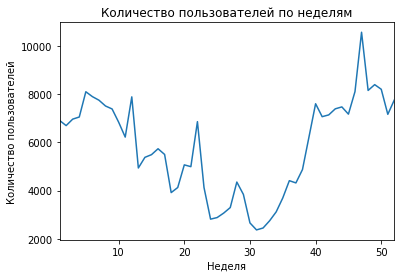

In [14]:
visits_week['n_users'].plot()
plt.title('Количество пользователей по неделям')
plt.ylabel('Количество пользователей')
plt.xlabel('Неделя')
plt.show()

In [15]:
visits_week['n_users'].mean()#.round()

5825.288461538462

В среднем в неделю 5825 пользователей заходят на сайт.Наибольшее количество посещений это 47 неделя(последняя неделя ноября).Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений в 31 неделю(конец июля-начало августа)- период отпусков и наиболее теплой погоды, позволяющей отдохнуть на природе.

In [16]:
#Посчитаем пользователей по месяцам
visits_month = visits.groupby('start_month').agg({'Uid': ['count','nunique']})
visits_month.columns = ['n_sessions', 'n_users']
visits_month.sort_values('n_users',ascending=False) 

,n_sessions,n_users
start_month,,
11,43969,32797
12,41983,31557
10,37903,29692
2,37182,28749
1,36939,28716
3,35677,27473
4,26515,21008
5,26635,20701
9,23907,18975


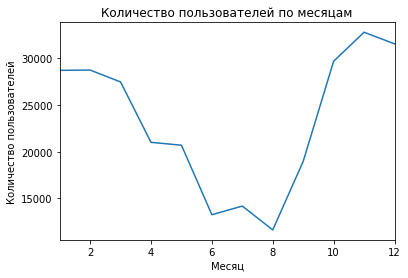

In [17]:
visits_month['n_users'].plot()
plt.title('Количество пользователей по месяцам')
plt.ylabel('Количество пользователей')
plt.xlabel('Месяц')
plt.show()

In [18]:
visits_month['n_users'].mean()#.round()

23228.416666666668

В среднем в месяц 23228 пользователей заходят на сайт.Наибольшее количество посещений это ноябрь.Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений август- период отпусков и наиболее теплой погоды, позволяющей отдохнуть на природе.

In [19]:
#Посчитаем пользователей по дням недели
visits_weekday = visits.groupby('start_day').agg({'Uid': ['count','nunique']})
visits_weekday.columns = ['n_sessions', 'n_users']
visits_weekday.sort_values('n_users',ascending=False) 


,n_sessions,n_users
start_day,,
3,58523,47190
0,56301,45207
4,54584,44200
1,54518,44019
2,52956,43154
5,41755,35110
6,40761,34418


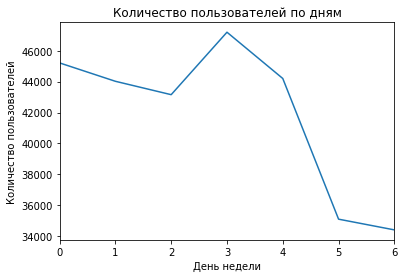

In [20]:
visits_weekday['n_users'].plot()
plt.title('Количество пользователей по дням')
plt.ylabel('Количество пользователей')
plt.xlabel('День недели')
plt.show()

Интересно, что четверг - лидер по посещаемости из дней недели.Возможно это связано с накоплением рабочей усталости к концу недели. А суббота и воскресенье - наимение посещаемые дни. Видимо в выходные у людей есть более интересные дела)

In [21]:
#DAU
dau_visits = visits.groupby('start_date').agg({'Uid': 'nunique'}).mean()
dau_visits

Uid    907.991758
dtype: float64

**<font color="blue">
Количество уникальных пользователей в день - 908</font>**

**<font color="blue">
Действительно, группировка по месяцам и по неделям выполнена по убыванию количества уникальных 
пользователей.Такой вывод легче читается глазами + мы сразу видими максимум и минимум. У нас данные с 2018-05-31 
23:59:00 по 2017-06-01 00:01:00. То есть нет дублей месяцев и недель за разный год, поэтому нет смысла разбивать
еще и по году.</font>**

#### количество сессий в день

In [22]:
#Посчитаем количество сессий в день
session_per_day = visits['Uid'].count() / 365
session_per_day

984.6520547945205

В день в среднем получается порядка 985 сессий.

#### продолжительность сессии

In [23]:
#Посчитаем продолжительность сессии
visits['session_duration'] = (visits['End Ts']-visits['Start Ts']).dt.seconds
visits.head()

,Device,End Ts,Source Id,Start Ts,Uid,start_day,start_week,start_month,start_date,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2,51,12,2017-12-20,1080
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,0,8,2,2018-02-19,1680
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,5,26,7,2017-07-01,0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,6,20,5,2018-05-20,1440
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2,52,12,2017-12-27,0


In [24]:
#Посчитаем количество сессий на одного пользователя
sessions_per_user = visits.groupby('start_month').agg({'Uid': ['count','nunique']})
sessions_per_user.columns = ['n_sessions', 'n_users']
sessions_per_user['sessions_per_user'] = sessions_per_user['n_sessions'] / sessions_per_user['n_users']
sessions_per_user

,n_sessions,n_users,sessions_per_user
start_month,,,
1,36939,28716,1.286356
2,37182,28749,1.293332
3,35677,27473,1.298620
4,26515,21008,1.262138
5,26635,20701,1.286653
6,16505,13259,1.244815
7,17828,14183,1.256998
8,14355,11631,1.234202
9,23907,18975,1.259921


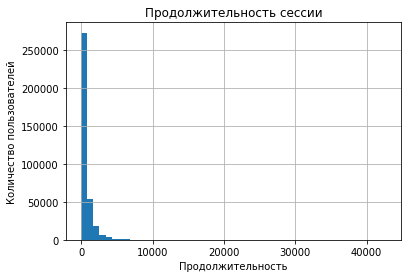

In [25]:
visits['session_duration'].hist(bins=50)
plt.title('Продолжительность сессии')
plt.ylabel('Количество пользователей')
plt.xlabel('Продолжительность')
plt.show()

In [26]:
session_time = visits['session_duration'].mode()
session_time

0    60
dtype: int64

Средняя продолжительность сессии 60 секунд. На одного пользователя приходится порядка 1.25 сессий.

#### Retention Rate


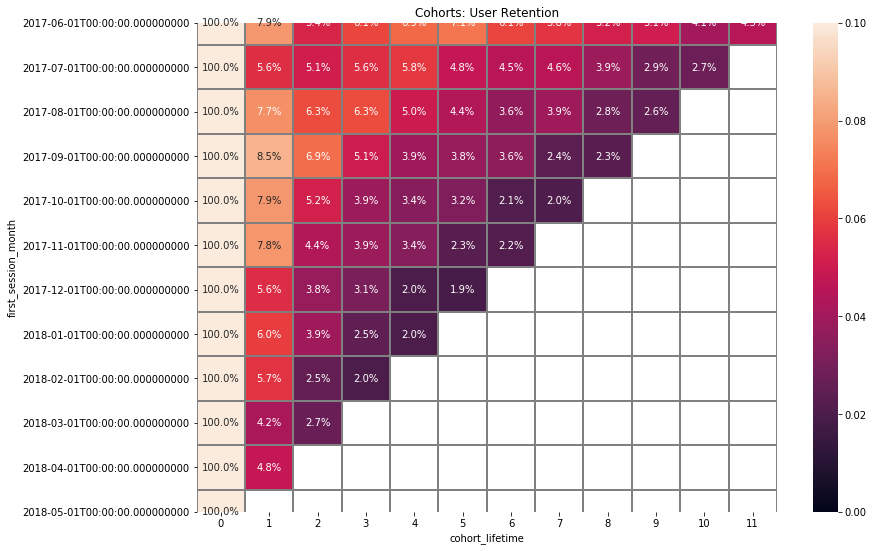

In [27]:
#Retention Rate
visits['session_date'] = pd.to_datetime(visits['Start Ts'])
visits['session_month'] = visits['Start Ts'].astype('datetime64[M]')

#Определим событие и период — на их основе сформируем когорту
first_visits_date = visits.groupby('Uid').agg({'session_month': 'min'}).reset_index()
first_visits_date.columns = ['Uid', 'first_session_month']

visits_new = pd.merge(visits,first_visits_date,on='Uid')

visits_new['cohort_lifetime'] = visits_new['session_month'] - visits_new['first_session_month']
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime'] / np.timedelta64(1,'M')
visits_new['cohort_lifetime'] = visits_new['cohort_lifetime'].round().astype('int')

#Сгруппируем данные по когорте и lifetime.
cohorts = visits_new.groupby(['first_session_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_session_month','Uid']]
initial_users_count = initial_users_count.rename(columns={'Uid':'cohort_users'})

#Объединим данные по когортам с исходным количеством пользователей в когорте
cohorts = cohorts.merge(initial_users_count,on='first_session_month')
cohorts['retention'] = cohorts['Uid']/cohorts['cohort_users'] #рассчитаем Retention Rate

retention_pivot = cohorts.pivot_table(index='first_session_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmin=0, vmax=0.1)
plt.ylabel('first_session_month')
plt.xlabel('cohort_lifetime')
plt.show()

Retention Rate для когорты 2017-06 в течении всего времени остается выше , чем для ранних когорт и начинает регулярно понижаться лишь с седьмого месяца жизни.На второй месяц жизни когорт был рост RR, но начиная с когорты 2017-11 обозначилась тенденция на снижение RR. Судя по RR более молодых когорт, нужно что-то менять в политике привлечения и удержания пользователей.

**<font color="blue">
#### Вывод    
В среднем в неделю 5825 пользователей заходят на сайт.Наибольшее количество посещений это 47 неделя(последняя неделя ноября).Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений в 31 неделю(конец июля-начало августа)- период отпусков и наиболее теплой погоды, позволяющей отдохнуть на природе.В среднем в месяц 23228 пользователей заходят на сайт.Наибольшее количество посещений это ноябрь.Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений август- период отпусков и наиболее теплой погоды.Интересно, что четверг - лидер по посещаемости из дней недели.Возможно это связано с накоплением рабочей усталости к концу недели. А суббота и воскресенье - наимение посещаемые дни. Видимо в выходные у людей есть более интересные дела).Количество уникальных пользователей в день — 908.В день в среднем получается порядка 985 сессий.Средняя продолжительность сессии 60 секунд. На одного пользователя приходится порядка 1.25 сессий.Retention Rate для когорты 2017-06 в течении всего времени остается выше , чем для ранних когорт и начинает регулярно понижаться лишь с седьмого месяца жизни.На второй месяц жизни когорт был рост RR, но начиная с когорты 2017-11 обозначилась тенденция на снижение RR. Судя по RR более молодых когорт, нужно что-то менять в политике привлечения и удержания пользователей.</font>**

### 2.2. Продажи
- Когда люди начинают покупать?
- Сколько раз покупают за период?
- Какой средний чек?
- Сколько денег приносят? (LTV)

#### Начало покупок

In [28]:
#Выделем  месяц и дату первой покупки
orders['orders_date'] = pd.to_datetime(orders['Buy Ts'])
orders['orders_month'] = orders['Buy Ts'].astype('datetime64[M]')
first_order_date = orders.groupby('Uid').agg({'orders_date': 'min'}).reset_index()
first_order_date.columns = ['Uid', 'first_order_date']
orders = pd.merge(orders,first_order_date,on='Uid')
orders.head()


,Buy Ts,Revenue,Uid,orders_date,orders_month,first_order_date
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00


In [29]:
#Определим время между первой сессией и первой покупкой
first_date = visits.groupby('Uid').agg({'session_date': 'min'}).reset_index()
first_date.columns = ['Uid', 'first_session_date']
vis_ord = pd.merge(orders,first_date,on='Uid')
vis_ord['time_start_buy'] = (vis_ord['first_order_date'] - vis_ord['first_session_date'])
vis_ord['time_start_buy'] = vis_ord['time_start_buy'].dt.total_seconds().astype('int')
vis_ord.head()


,Buy Ts,Revenue,Uid,orders_date,orders_month,first_order_date,first_session_date,time_start_buy
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00,2017-06-01 00:09:00,60
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00,2017-06-01 00:14:00,660
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00,2017-06-01 00:25:00,120
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00,2017-06-01 00:14:00,900
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00,2017-06-01 07:31:00,1620


In [30]:
vis_ord['time_start_buy'].max()

31388640

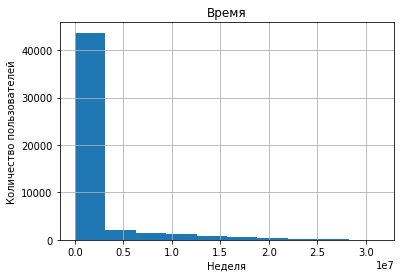

In [31]:
vis_ord['time_start_buy'].hist()
plt.title('Время')
plt.ylabel('Количество пользователей')
plt.xlabel('Неделя')
plt.show()

In [32]:
time_bs = vis_ord['time_start_buy'].median()
time_bs

1320.0

Большинство пользователей переходят в статус покупателей менее чем через три часа, но есть и те, у кого на это уходит больше времени (вплоть до суток).Поэтому посчитаем медианное значение, которое равно 22 минутам.

#### Сколько покупают

In [33]:
#Посчитаем по месяцам количество пукупателей и количество покупок

count_orders_by_users = orders.groupby(['orders_month']).agg({'Uid':'count'}).reset_index()
count_orders_by_users.columns = ['orders_month', 'orders_count']

count_orders_by_uid = orders.groupby(['orders_month']).agg({'Uid':'nunique'}).reset_index()
count_orders_by_uid.columns = ['orders_month', 'unique']

count_orders_by_users = pd.merge(count_orders_by_uid,count_orders_by_users,on='orders_month')
count_orders_by_users['persen_orders_per_month'] = count_orders_by_users['orders_count']/count_orders_by_users['unique']
count_orders_by_users

,orders_month,unique,orders_count,persen_orders_per_month
0,2017-06-01,2023,2354,1.163618
1,2017-07-01,1984,2363,1.191028
2,2017-08-01,1472,1807,1.227582
3,2017-09-01,2750,3387,1.231636
4,2017-10-01,4675,5679,1.214759
5,2017-11-01,4547,5659,1.244557
6,2017-12-01,4942,6218,1.258195
7,2018-01-01,3898,4721,1.211134
8,2018-02-01,4258,5281,1.240254
9,2018-03-01,4181,5326,1.273858


In [34]:
count_orders_by_users['persen_orders_per_month'].mean()

1.2058233446244648

**<font color="blue">
В среднем на одного пользователя в месяц приходится 1.2 покупки</font>**

In [35]:
#Посмотрим по месячным когортам сколько покупают
first_orders_month = vis_ord.groupby('Uid').agg({'orders_month': 'min'}).reset_index()
first_orders_month.columns = ['Uid', 'first_orders_month']
vis_ord = pd.merge(vis_ord,first_orders_month,on='Uid')

vis_ord['cohort_lifetime'] = vis_ord['orders_month'] - vis_ord['first_orders_month']
vis_ord['cohort_lifetime'] = vis_ord['cohort_lifetime'] / np.timedelta64(1,'M')
vis_ord['cohort_lifetime'] = vis_ord['cohort_lifetime'].round().astype('int')
cohorts_new = vis_ord.groupby(['first_orders_month','cohort_lifetime']).agg({'Uid':'nunique'}).reset_index()

buy_count = cohorts_new[cohorts_new['cohort_lifetime'] == 0][['first_orders_month','Uid']]
buy_count = buy_count.rename(columns={'Uid':'cohort_users'})

cohorts_new = cohorts_new.merge(buy_count,on='first_orders_month')
purchase = cohorts_new.pivot_table(index='first_orders_month',
                                      columns='cohort_lifetime',
                                      values='Uid',
                                      aggfunc='sum')
purchase


cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,2023.0,61.0,50.0,54.0,88.0,67.0,62.0,47.0,58.0,45.0,45.0,53.0
2017-07-01,1923.0,52.0,57.0,64.0,49.0,38.0,36.0,39.0,42.0,22.0,26.0,NaN
2017-08-01,1370.0,58.0,53.0,44.0,40.0,32.0,30.0,44.0,19.0,31.0,NaN,NaN
2017-09-01,2581.0,130.0,100.0,74.0,52.0,64.0,66.0,37.0,43.0,NaN,NaN,NaN
2017-10-01,4340.0,206.0,123.0,92.0,93.0,72.0,56.0,67.0,NaN,NaN,NaN,NaN
2017-11-01,4081.0,222.0,120.0,106.0,81.0,48.0,62.0,NaN,NaN,NaN,NaN,NaN
2017-12-01,4383.0,146.0,103.0,97.0,50.0,63.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3373.0,114.0,83.0,43.0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3651.0,118.0,58.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


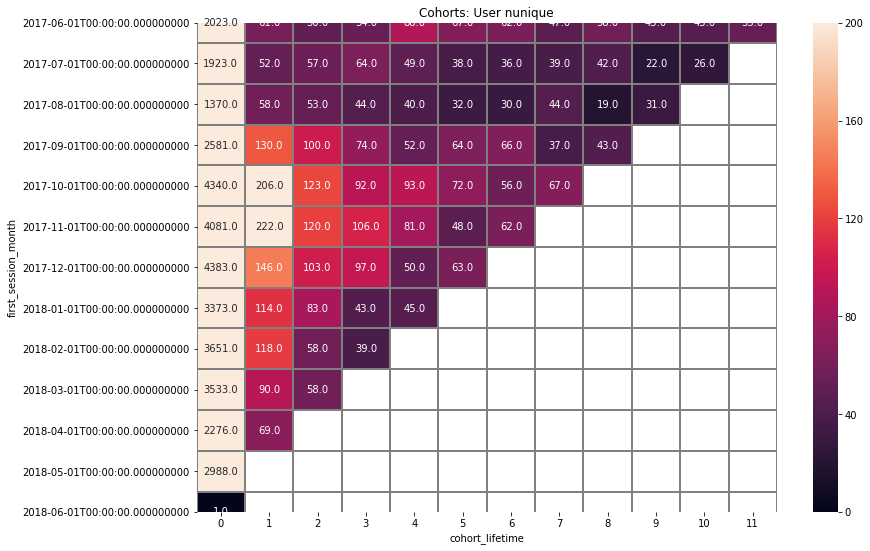

In [36]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User nunique')
sns.heatmap(purchase, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=0, vmax=200)
plt.ylabel('first_session_month')
plt.xlabel('cohort_lifetime')
plt.show()

**<font color="blue">
Количество уникальных пользователей , сделавших покупки в когртах распределено неравномерно в течении жизни.Нет четко видимых  всплесков или падений.Однако второй месяц жизни для когорт  2017-09,2017-10, 2017-11 отметился резким многократным увеличением количества покупок от уникальных пользователей , что коррелирует с ростом количества пользователей в ноябре, который мы отметели в анализе помесячной активности.Для когорты 2017-11  222 покупки от уникальных пользователей за месяц - абсолютный рекорд по всем представленным когортам. Самое низкое число покупок - 19 у когорты 2017-08 на 8 месяц жизни.</font>**

#### Выручку с пользователя

In [37]:
# Считаем среднюю выручку по когортам
coh = vis_ord.groupby(['first_orders_month','cohort_lifetime']).agg({'Revenue':'sum'}).reset_index()



revenue_count = coh[coh['cohort_lifetime'] == 0][['first_orders_month','Revenue']]
revenue_count = buy_count.rename(columns={'Uid':'cohort_revenue'})

cohorts_revenue = coh.merge(revenue_count,on='first_orders_month')
revenue_pivot = cohorts_revenue.pivot_table(index='first_orders_month',
                                      columns='cohort_lifetime',
                                      values='Revenue',
                                      aggfunc='mean')
revenue_pivot

cohort_lifetime,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,9557.49,981.82,885.34,1931.30,2068.58,1487.92,1922.74,1176.56,1119.15,1225.51,1155.66,519.62
2017-07-01,11557.65,644.61,1199.05,690.31,339.97,300.08,231.16,272.72,310.05,282.96,299.36,NaN
2017-08-01,7228.83,646.63,628.12,536.05,676.85,388.45,288.61,554.86,400.33,257.53,NaN,NaN
2017-09-01,14568.53,2884.49,1344.52,10261.52,1033.84,1670.08,1810.85,627.57,474.92,NaN,NaN,NaN
2017-10-01,21716.20,2325.21,830.65,682.01,657.77,522.37,368.10,501.14,NaN,NaN,NaN,NaN
2017-11-01,21036.26,1629.27,814.39,1326.13,604.04,219.88,469.02,NaN,NaN,NaN,NaN,NaN
2017-12-01,20767.49,1141.22,4054.70,4669.10,1371.57,1481.66,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,13949.50,994.22,1026.34,481.59,211.48,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,15177.16,1015.98,286.66,270.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


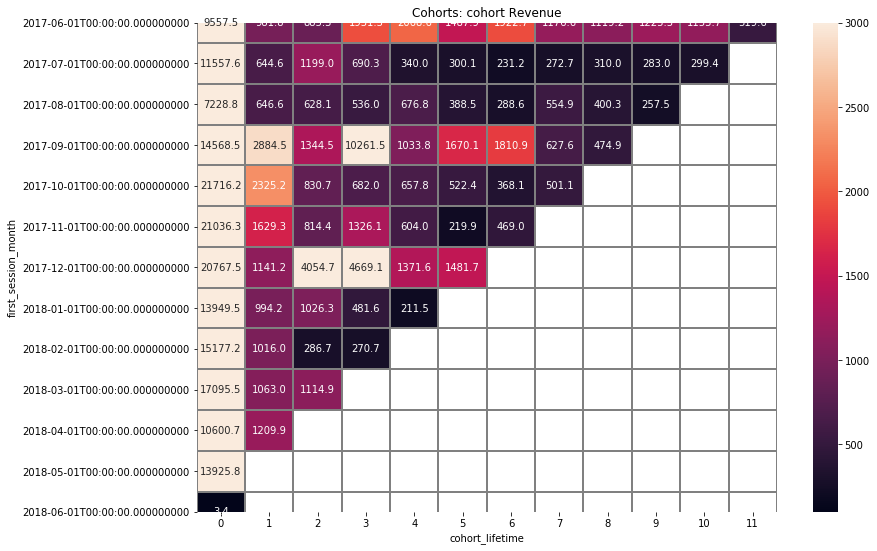

In [38]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: cohort Revenue')
sns.heatmap(revenue_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=100, vmax=3000)
plt.ylabel('first_session_month')
plt.xlabel('cohort_lifetime')
plt.show()

Видим, что выручка также распределена неравномерно по жизни когорты. Самая большая выручка с 2017-10, 2017-11,2017-12 когорт, а самой маленькая с когорты 2017-08.

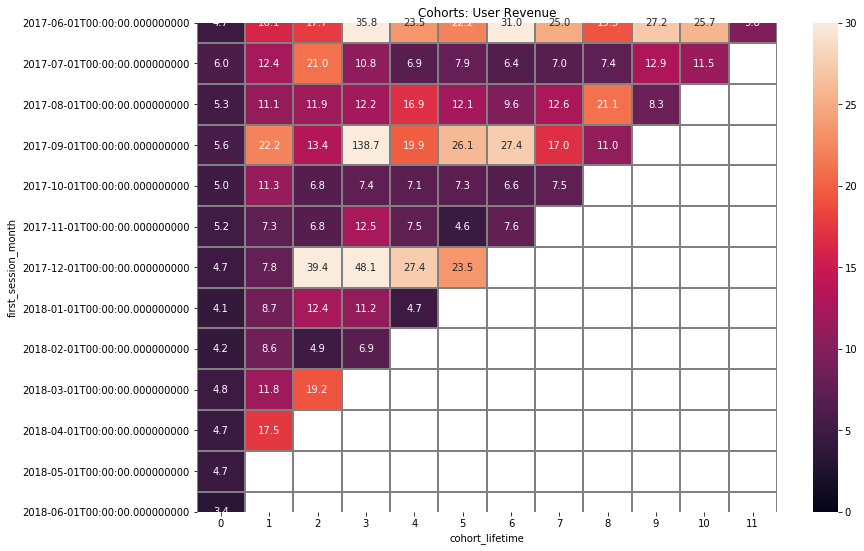

In [39]:
#Прибыль с одного пользователя
coh_1 = vis_ord.groupby(['first_orders_month','cohort_lifetime']).agg({'Revenue':'sum','Uid':'nunique'}).reset_index()
coh_1['pers_rev'] = coh_1['Revenue']/coh_1['Uid']
pers_rev = coh_1.merge(revenue_count,on='first_orders_month')
pers_rev_pivot = pers_rev.pivot_table(index='first_orders_month',
                                      columns='cohort_lifetime',
                                      values='pers_rev',
                                      aggfunc='mean')
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User Revenue')
sns.heatmap(pers_rev_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray', vmin=0, vmax=30)
plt.ylabel('first_session_month')
plt.xlabel('cohort_lifetime')
plt.show()

**<font color="blue">
В среднем наибольшую выручку принес пользователь когорты 2017-07 в размере 6 рублей.Наименьшую выручку принес пользователь когорты 2018-01 в размере 4.1 рубля. Есть интересный всплеск у пользователей когорты 2017-09 на четвертый месяц жизни - 138.7 рублей.Интересно, чем был вызван такой скачок.</font>**

In [40]:
orders['Revenue'].describe()

count    50415.000000
mean         4.999647
std         21.818359
min          0.000000
25%          1.220000
50%          2.500000
75%          4.890000
max       2633.280000
Name: Revenue, dtype: float64

Средний чек: 5 рублей.

#### LTV

In [41]:
#ltv
costs['month'] = costs['dt'].astype('datetime64[M]')


costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [42]:
#Получим месяц первой покупки каждого покупателя

fom = vis_ord.groupby('Uid').agg({'orders_month': 'min'}).reset_index()
fom.columns = ['Uid', 'first_orders_month']
visord = pd.merge(orders,first_date,on='Uid')
visord = pd.merge(visord,fom,on='Uid')

#Посчитаем количество новых покупателей (n_buyers) за каждый месяц
cohort_sizes = visord.groupby('orders_month').agg({'Uid': 'nunique'}).reset_index()
cohort_sizes.columns = ['first_orders_month', 'n_buyers']
cohort_sizes.head()


,first_orders_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1984
2,2017-08-01,1472
3,2017-09-01,2750
4,2017-10-01,4675


In [43]:
#Добавим месяц первой покупки каждого покупателя в таблицу с заказами
order_new = pd.merge(orders,fom, on='Uid')
order_new.head()

,Buy Ts,Revenue,Uid,orders_date,orders_month,first_order_date,first_orders_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01 00:10:00,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01 00:25:00,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01 00:27:00,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01 00:29:00,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01 07:58:00,2017-06-01,2017-06-01 07:58:00,2017-06-01


In [44]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку
coh_ord = order_new.groupby(['first_orders_month','orders_month']).agg({'Revenue': 'sum'}).reset_index()
coh_ord.head()

,first_orders_month,orders_month,Revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [45]:
report = pd.merge(cohort_sizes, coh_ord, on='first_orders_month')
report.head()

,first_orders_month,n_buyers,orders_month,Revenue
0,2017-06-01,2023,2017-06-01,9557.49
1,2017-06-01,2023,2017-07-01,981.82
2,2017-06-01,2023,2017-08-01,885.34
3,2017-06-01,2023,2017-09-01,1931.30
4,2017-06-01,2023,2017-10-01,2068.58


In [46]:
#вычислим возраст когорты
report['age'] = (report['orders_month'] - report['first_orders_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')
report.head()


,first_orders_month,n_buyers,orders_month,Revenue,age
0,2017-06-01,2023,2017-06-01,9557.49,0
1,2017-06-01,2023,2017-07-01,981.82,1
2,2017-06-01,2023,2017-08-01,885.34,2
3,2017-06-01,2023,2017-09-01,1931.30,3
4,2017-06-01,2023,2017-10-01,2068.58,4


In [47]:
#вычислим ltv

report['ltv'] = report['Revenue'] / report['n_buyers']
    
ltv = report.pivot_table(
        index='first_orders_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean')
    
ltv.fillna('')
ltv


age,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,4.724414,0.485329,0.437637,0.954671,1.022531,0.735502,0.950440,0.581592,0.553213,0.605788,0.571261,0.256856
2017-07-01,5.825428,0.324904,0.604360,0.347939,0.171356,0.151250,0.116512,0.137460,0.156275,0.142621,0.150887,NaN
2017-08-01,4.910890,0.439287,0.426712,0.364164,0.459817,0.263893,0.196067,0.376943,0.271963,0.174952,NaN,NaN
2017-09-01,5.297647,1.048905,0.488916,3.731462,0.375942,0.607302,0.658491,0.228207,0.172698,NaN,NaN,NaN
2017-10-01,4.645176,0.497371,0.177679,0.145884,0.140699,0.111737,0.078738,0.107196,NaN,NaN,NaN,NaN
2017-11-01,4.626404,0.358318,0.179105,0.291649,0.132844,0.048357,0.103149,NaN,NaN,NaN,NaN,NaN
2017-12-01,4.202244,0.230923,0.820457,0.944779,0.277533,0.299810,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,3.578630,0.255059,0.263299,0.123548,0.054253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,3.564387,0.238605,0.067323,0.063574,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


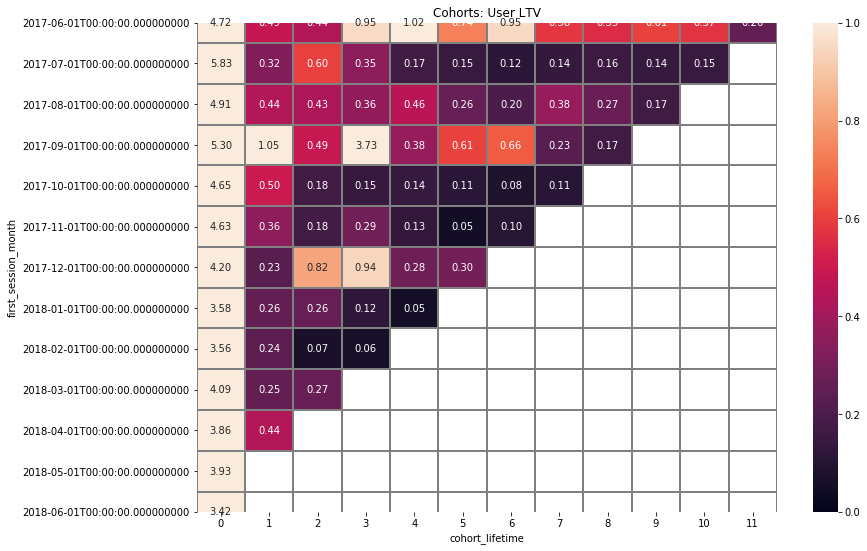

In [48]:
plt.figure(figsize=(13, 9))
plt.title('Cohorts: User LTV')
sns.heatmap(ltv, annot=True, fmt='.2f', linewidths=1, linecolor='gray', vmin=0, vmax=1)
plt.ylabel('first_session_month')
plt.xlabel('cohort_lifetime')
plt.show()

In [49]:
ltv_201706 = ltv.loc['2017-06-01'].sum()
print('Для когорты 201706 ltv',ltv_201706)

ltv_201707 = ltv.loc['2017-07-01'].sum()
print('Для когорты 201707 ltv',ltv_201707)

ltv_201708 = ltv.loc['2017-08-01'].sum()
print('Для когорты 201708 ltv',ltv_201708)

ltv_201709 = ltv.loc['2017-09-01'].sum()
print('Для когорты 201709 ltv',ltv_201709)

ltv_201710 = ltv.loc['2017-10-01'].sum()
print('Для когорты 201710 ltv',ltv_201710)

ltv_201711 = ltv.loc['2017-11-01'].sum()
print('Для когорты 201711 ltv',ltv_201711)

Для когорты 201706 ltv 11.879233811171527
Для когорты 201707 ltv 8.128991935483858
Для когорты 201708 ltv 7.884687499999989
Для когорты 201709 ltv 12.609570909090921
Для когорты 201710 ltv 5.904481283422433
Для когорты 201711 ltv 5.739826259071875


Посчтитав ltv для когорт, чья длительность жизни не менее полугода, можно увидеть, что покупатель из когорты 201706 принес 11.8 рубля за год и клиенты из других когорт принесут схожую прибыль. Но выделяется когорта 201709,покупатель из которой принес за 9 месяцев 12.6 рубля. Возможно для этой когорты была какая-то акция или дополнительная реклама , способствующая росту покупок.

**<font color="blue">
В выводе я сравниваю показатели за 6 месяцев, следуя следующей логике: так как LTV - накопительный показатель, то не совсем корректно сравнивать его у когорт с очень маленькой продолжительностью жизни. В нашем случае период один год, поэтому и сравнивать нужно те когорты, которые прожили хотя бы половину этого периода.</font>**



#### Вывод
**<font color="blue">
Большинство пользователей переходят в статус покупателей менее чем через три часа, но есть и те, у кого на это уходит больше времени (вплоть до суток).Поэтому посчитаем медианное значение, которое равно 22 минутам.
В среднем на одного пользователя в месяц приходится 1.2 покупки
Количество уникальных пользователей , сделавших покупки в когртах распределено неравномерно в течении жизни.Нет четко видимых  всплесков или падений.Однако второй месяц жизни для когорт  2017-09,2017-10, 2017-11 отметился резким многократным увеличением количества покупок от уникальных пользователей , что коррелирует с ростом количества пользователей в ноябре, который мы отметели в анализе помесячной активности.Для когорты 2017-11  222 покупки от уникальных пользователей за месяц - абсолютный рекорд по всем представленным когортам. Самое низкое число покупок - 19 у когорты 2017-08 на 8 месяц жизни.
Видим, что выручка также распределена неравномерно по жизни когорты. Самая большая выручка с 2017-10, 2017-11,2017-12 когорт, а самой маленькая с когорты 2017-08.
В среднем наибольшую выручку принес пользователь когорты 2017-07 в размере 6 рублей.Наименьшую выручку принес пользователь когорты 2018-01 в размере 4.1 рубля. Есть интересный всплеск у пользователей когорты 2017-09 на четвертый месяц жизни - 138.7 рублей.Интересно, чем был вызван такой скачок.
Средний чек: 5 рублей.
Посчтитав ltv для когорт, чья длительность жизни не менее полугода, можно увидеть, что покупатель из когорты 201706 принес 11.8 рубля за год и клиенты из других когорт принесут схожую прибыль. Но выделяется когорта 201709,покупатель из которой принес за 9 месяцев 12.6 рубля. Возможно для этой когорты была какая-то акция или дополнительная реклама , способствующая росту покупок.
</font>**

### 2.3 Маркетинг
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько стоило привлечение одного покупателя из каждого источника?
- На сколько окупились расходы? (ROI)

In [50]:
#Общие затраты
costs_total = costs['costs'].sum()
costs_total

329131.62

In [51]:
costs.head()

,source_id,dt,costs,month
0,1,2017-06-01,75.20,2017-06-01
1,1,2017-06-02,62.25,2017-06-01
2,1,2017-06-03,36.53,2017-06-01
3,1,2017-06-04,55.00,2017-06-01
4,1,2017-06-05,57.08,2017-06-01


In [52]:
# затраты на источники
costs_source = costs.groupby('source_id')['costs'].sum().reset_index()

costs_source

,source_id,costs
0,1,20833.27
1,2,42806.04
2,3,141321.63
3,4,61073.60
4,5,51757.10
5,9,5517.49
6,10,5822.49


In [53]:
# затраты по месяцам
costs_month = costs.groupby('month')['costs'].sum().reset_index()

costs_month

,month,costs
0,2017-06-01,18015.00
1,2017-07-01,18240.59
2,2017-08-01,14790.54
3,2017-09-01,24368.91
4,2017-10-01,36322.88
5,2017-11-01,37907.88
6,2017-12-01,38315.35
7,2018-01-01,33518.52
8,2018-02-01,32723.03
9,2018-03-01,30415.27


**<font color="blue">
Общие затраты - 329131.62 рублей. Самым затратным рекламным источником стал №3(141321.63 руб.), а самым незатратным - №9(5517.49 руб.).В декабре на рекламу  было потрачено больше всего - 38315.35руб., а в июне меньше всего - 18015.00 руб.</font>**


#### На сколько окупились расходы

In [54]:
#CAC gпо месяцам
report_new = pd.merge(report, costs_month, left_on='first_orders_month', right_on='month')
report_new['cac'] = report_new['costs'] / report_new['n_buyers']
report_new_cac = report_new.groupby('first_orders_month')['cac'].mean()
report_new_cac


first_orders_month
2017-06-01     8.905091
2017-07-01     9.193846
2017-08-01    10.047921
2017-09-01     8.861422
2017-10-01     7.769600
2017-11-01     8.336899
2017-12-01     7.753005
2018-01-01     8.598902
2018-02-01     7.685070
2018-03-01     7.274640
2018-04-01     8.122952
2018-05-01     6.270957
Name: cac, dtype: float64

In [55]:
#Считаем romi,так как из затрат у нас есть только  маркетинг
report_new['romi'] = report_new['ltv'] / report_new['cac']
romi = report_new.pivot_table(
        index='first_orders_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')

romi.cumsum(axis=1).round(2)


age,0,1,2,3,4,5,6,7,8,9,10,11
first_orders_month,,,,,,,,,,,,
2017-06-01,0.53,0.59,0.63,0.74,0.86,0.94,1.05,1.11,1.17,1.24,1.31,1.33
2017-07-01,0.63,0.67,0.73,0.77,0.79,0.81,0.82,0.84,0.85,0.87,0.88,NaN
2017-08-01,0.49,0.53,0.57,0.61,0.66,0.68,0.70,0.74,0.77,0.78,NaN,NaN
2017-09-01,0.60,0.72,0.77,1.19,1.23,1.30,1.38,1.40,1.42,NaN,NaN,NaN
2017-10-01,0.60,0.66,0.68,0.70,0.72,0.74,0.75,0.76,NaN,NaN,NaN,NaN
2017-11-01,0.55,0.60,0.62,0.65,0.67,0.68,0.69,NaN,NaN,NaN,NaN,NaN
2017-12-01,0.54,0.57,0.68,0.80,0.84,0.87,NaN,NaN,NaN,NaN,NaN,NaN
2018-01-01,0.42,0.45,0.48,0.49,0.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-01,0.46,0.49,0.50,0.51,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Считаем romi,так как из затрат у нас есть только  маркетинг.
Июньская когорта окупилась на 7 месяц (ROMI = 1.05).
Сентябрьская когорта окупилась на 4 месяц тоже (ROMI = 1.19).
Вообще из 12 когорт  окупились только две и и еще две близки к этому.

In [56]:
#Усредним значения каждой колонки 
romi.cumsum(axis=1).mean(axis=0)


age
0     0.540816
1     0.581985
2     0.631069
3     0.719740
4     0.782946
5     0.859876
6     0.896819
7     0.969951
8     1.053871
9     0.964488
10    1.094658
11    1.333982
dtype: float64

В среднем когорты окупаются к 9 месяцу.

#### Сколько стоило привлечение одного покупателя из каждого источника

In [57]:
users = visits.sort_values(by = ['Uid', 'Start Ts'])
users = users.groupby('Uid').agg({'Start Ts' : 'first', 'Source Id': 'first', 'Device': 'first'}) 
users.sample()

,Start Ts,Source Id,Device
Uid,,,
14790573073069374187,2017-10-20,9,desktop


In [58]:
usor = pd.merge(orders,users,on='Uid')
usor.sample()


,Buy Ts,Revenue,Uid,orders_date,orders_month,first_order_date,Start Ts,Source Id,Device
19248,2017-11-30 17:12:00,1.59,12482518978263426565,2017-11-30 17:12:00,2017-11-01,2017-10-31 08:09:00,2017-10-31 07:55:00,4,desktop


In [59]:
cd = usor.groupby(['Source Id','orders_month','Device']).agg({'Revenue': 'sum'}).reset_index()
coh_sizes = usor.groupby('orders_month').agg({'Uid': 'nunique'}).reset_index()
coh_sizes.columns = ['orders_month', 'n_buyers']
rt = pd.merge(coh_sizes, cd, on='orders_month')
rt.sample()


,orders_month,n_buyers,Source Id,Device,Revenue
36,2017-08-01,1472,5,desktop,1898.98


In [60]:
#LTV и CAC по рекламным источникам
rt['ltv'] = rt['Revenue'] / rt['n_buyers']
rt = rt.rename(columns={"Source Id": "source_id"})
rt_new = pd.merge(rt, costs_source, on='source_id')
rt_new['cac'] = rt_new['costs'] / rt_new['n_buyers']
rt_new.groupby('source_id')[['ltv','cac']].mean().reset_index()


,source_id,ltv,cac
0,1,0.392127,7.039349
1,2,0.540617,14.463724
2,3,0.676794,47.751138
3,4,0.787770,2462.754701
4,5,0.622799,17.488196
5,9,0.070502,1.864304
6,10,0.054227,1.967360


**<font color="blue">
Дороже всего обходится привлечение покупателя источником №4  2462рубля, дешевле всего привлечение покупателя источником №9 1.86рублей. </font>**


In [61]:
#romi  по рекламным источникам
rt_new['romi'] = rt_new['ltv'] / rt_new['cac']

rt_new.groupby('source_id')['romi'].mean().reset_index()


,source_id,romi
0,1,0.062181
1,2,0.045675
2,3,0.016072
3,4,0.037133
4,5,0.042365
5,9,0.043494
6,10,0.031847


In [62]:
#romi по устройствам
rt_new.groupby('Device')['romi'].mean().reset_index()

,Device,romi
0,desktop,0.066220
1,touch,0.013081


#### Вывод
**<font color="blue">
Общие затраты - 329131.62 рублей. Самым затратным рекламным источником стал №3(141321.63 руб.), а самым незатратным - №9(5517.49 руб.).В декабре на рекламу  было потрачено больше всего - 38315.35руб., а в июне меньше всего - 18015.00 руб.
Июньская когорта окупилась на 7 месяц (ROMI = 1.05).
Сентябрьская когорта окупилась на 4 месяц тоже (ROMI = 1.19).
Вообще из 12 когорт  окупились только две и и еще две близки к этому.
Дороже всего обходится привлечение покупателя источником №4  2462рубля, дешевле всего привлечение покупателя источником №9 1.86рублей.
</font>**

### <a id='3'>Шаг 3. Напишите вывод: порекомендуйте маркетологам, куда и сколько им стоит вкладывать денег?</a> 
Какие источники/платформы вы бы порекомендовали? Объясните свой выбор: на какие метрики вы ориентируетесь? Почему? Какие выводы вы сделали, узнав значение метрик?

В среднем в неделю 5825 пользователей заходят на сайт.Наибольшее количество посещений это 47 неделя(последняя неделя ноября).Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений в 31 неделю(конец июля-начало августа)- период отпусков и наиболее теплой погоды, позволяющей отдохнуть на природе.
В среднем в месяц 23228 пользователей заходят на сайт.Наибольшее количество посещений это ноябрь.Возможно это связано с периодом скидок, который приходится как раз на это время.Плюс зима на пороге и люди ищют развлечений в теплых помещениях)). И логично , что наименьшее количество посещений август- период отпусков и наиболее теплой погоды, позволяющей отдохнуть на природе.
Интересно, что четверг - лидер по посещаемости из дней недели.Возможно это связано с накоплением рабочей усталости к концу недели. А суббота и воскресенье - наимение посещаемые дни. Видимо в выходные у людей есть более интересные дела)
В день в среднем получается порядка 985 сессий.
**<font color="blue">
Количество уникальных пользователей в день - 908</font>**

Средняя продолжительность сессии 60 секунд. На одного пользователя приходится порядка 1.25 сессий.

Retention Rate для когорты 2017-06 в течении всего времени остается выше , чем для ранних когорт и начинает регулярно понижаться лишь с седьмого месяца жизни.На второй месяц жизни когорт был рост RR, но начиная с когорты 2017-11 обозначилась тенденция на снижение RR. Судя по RR более молодых когорт, нужно что-то менять в политике привлечения и удержания пользователей.

Большинство пользователей переходят в статус покупателей менее чем через три часа, но есть и те, у кого на это уходит больше времени (вплоть до суток).Поэтому посчитаем медианное значение, которое равно 22 минутам.
**<font color="blue">
В среднем на одного пользователя в месяц приходится 1.2 покупки</font>**

**<font color="blue">
Количество уникальных пользователей , сделавших покупки в когртах распределено неравномерно в течении жизни.Нет четко видимых  всплесков или падений.Однако второй месяц жизни для когорт  2017-09,2017-10, 2017-11 отметился резким многократным увеличением количества покупок от уникальных пользователей , что коррелирует с ростом количества пользователей в ноябре, который мы отметели в анализе помесячной активности.Для когорты 2017-11  222 покупки от уникальных пользователей за месяц - абсолютный рекорд по всем представленным когортам. Самое низкое число покупок - 19 у когорты 2017-08 на 8 месяц жизни.</font>**

Видим, что выручка также распределена неравномерно по жизни когорты. Самая большая выручка с 2017-10, 2017-11,2017-12 когорт, а самой маленькая с когорты 2017-08.
**<font color="blue">
В среднем наибольшую выручку принес пользователь когорты 2017-07 в размере 6 рублей.Наименьшую выручку принес пользователь когорты 2018-01 в размере 4.1 рубля. Есть интересный всплеск у пользователей когорты 2017-09 на четвертый месяц жизни - 138.7 рублей.Интересно, чем был вызван такой скачок.</font>**

Посчтитав ltv для когорт, чья длительность жизни не менее полугода, можно увидеть, что покупатель из когорты 201706 принес 11.8 рубля за год и клиенты из других когорт принесут схожую прибыль. Но выделяется когорта 201709,покупатель из которой принес за 9 месяцев 12.6 рубля. Возможно для этой когорты была какая-то акция или дополнительная реклама , способствующая росту покупок.

**<font color="blue">
Общие затраты - 329131.62 рублей. Самым затратным рекламным источником стал №3(141321.63 руб.), а самым незатратным - №9(5517.49 руб.).В декабре на рекламу  было потрачено больше всего - 38315.35руб., а в июне меньше всего - 18015.00 руб.</font>**


Июньская когорта окупилась на 7 месяц (ROMI = 1.05).
Сентябрьская когорта окупилась на 4 месяц тоже (ROMI = 1.19).
Вообще из 12 когорт  окупились только две и и еще две близки к этому.

В среднем когорты окупаются к 9 месяцу.

**<font color="blue">
Дороже всего обходится привлечение покупателя источником №4  2462рубля, дешевле всего привлечение покупателя источником №9 1.86рублей. </font>**